## Import Libraries and Load Data

In [ ]:
import librosa
import math 
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from scipy.io import wavfile
from scipy.stats import pearsonr
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  samplerate, data = wavfile.read(name_of_file)
  return samplerate, data

In [ ]:
link = 'https://drive.google.com/file/d/19cjRyyg5JSNwxe-jenWbR2oqeRMlHEnc/view?usp=sharing'
name = 'spikerboxdata.wav'
sr, data = DataLoader(link, name)

In [ ]:
def DataLoaderFER(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe

In [ ]:
link2 = 'https://drive.google.com/file/d/1BeQjxLWakyNGeljznZ1ysaGACR1YHExg/view?usp=sharing'
name2 = 'jazzflow-erkin.csv'
df_md = DataLoaderFER(link2, name2)

In [ ]:
df_md

,id,__typename,_lastChangedAt,_version,angry,createdAt,disgusted,fearful,happy,meetingID,neutral,owner,sad,score,surprised,timestamp,updatedAt
0,abc8abb8-b81c-4a8a-b390-d895735d809b,AudienceFaceExpression,1646846650995,1,0.374838,2022-03-09T17:24:10.994Z,1.328748e-06,7.488778e-09,0.000996,36bd0c41-77ef-4626-8602-119803ae6e04,0.620870,f6956996-c7bc-4971-a436-f034ccd4facc,0.003284,'-0.3771155880627417,1.132645e-05,1646846650298,2022-03-09T17:24:10.994Z
1,29b9974d-2e63-4c50-84c9-f00a76e18e06,AudienceFaceExpression,1646852661161,1,0.000154,2022-03-09T19:04:21.160Z,5.144679e-05,2.011098e-08,0.819734,36bd0c41-77ef-4626-8602-119803ae6e04,0.178700,f6956996-c7bc-4971-a436-f034ccd4facc,0.001361,0.8181676307008487,2.561990e-07,1646852660297,2022-03-09T19:04:21.160Z
2,4573861a-40b3-4e0f-a1f4-becb3fda76e5,AudienceFaceExpression,1646848991111,1,0.000284,2022-03-09T18:03:11.110Z,1.797050e-07,2.298866e-06,0.001661,36bd0c41-77ef-4626-8602-119803ae6e04,0.742777,f6956996-c7bc-4971-a436-f034ccd4facc,0.254499,'-0.2523486881522605,7.758179e-04,1646848990318,2022-03-09T18:03:11.110Z
3,46142906-fb9b-44ee-8161-b3e524660f5e,AudienceFaceExpression,1646847515015,1,0.147480,2022-03-09T17:38:35.014Z,1.363300e-03,6.096854e-05,0.071268,36bd0c41-77ef-4626-8602-119803ae6e04,0.558289,f6956996-c7bc-4971-a436-f034ccd4facc,0.215395,'-0.28688861581739816,6.143184e-03,1646847514287,2022-03-09T17:38:35.014Z
4,26ee064e-194d-4951-9746-120d065789b5,AudienceFaceExpression,1646854884278,1,0.004335,2022-03-09T19:41:24.278Z,1.516443e-05,5.082845e-06,0.473160,36bd0c41-77ef-4626-8602-119803ae6e04,0.375792,f6956996-c7bc-4971-a436-f034ccd4facc,0.146121,0.3232553771200699,5.714090e-04,1646854883318,2022-03-09T19:41:24.278Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12263,c20a2dd3-3f32-4e00-b4da-a4cb3ef3bf32,AudienceFaceExpression,1646849815046,1,0.003441,2022-03-09T18:16:55.045Z,9.786746e-04,3.493822e-04,0.128995,36bd0c41-77ef-4626-8602-119803ae6e04,0.678071,f6956996-c7bc-4971-a436-f034ccd4facc,0.188034,'-0.06367616578609159,1.317385e-04,1646849814261,2022-03-09T18:16:55.045Z
12264,af303d20-3cf3-48e7-84fb-9d5ed9416e8a,AudienceFaceExpression,1646856489244,1,0.025365,2022-03-09T20:08:09.243Z,1.495152e-03,1.419515e-03,0.214771,36bd0c41-77ef-4626-8602-119803ae6e04,0.388010,f6956996-c7bc-4971-a436-f034ccd4facc,0.080924,0.39358233295206446,2.880152e-01,1646856488288,2022-03-09T20:08:09.243Z
12265,f6f46279-6be4-49e9-9ec1-36ad85d938ec,AudienceFaceExpression,1646855525216,1,0.013979,2022-03-09T19:52:05.215Z,1.704393e-03,3.081495e-06,0.010688,36bd0c41-77ef-4626-8602-119803ae6e04,0.972606,f6956996-c7bc-4971-a436-f034ccd4facc,0.000688,'-0.005355208860351013,3.314306e-04,1646855524273,2022-03-09T19:52:05.215Z
12266,e8095552-5283-4dc3-b526-4a60feec3ccf,AudienceFaceExpression,1646854026188,1,0.014610,2022-03-09T19:27:06.188Z,7.095278e-07,1.349876e-07,0.000235,36bd0c41-77ef-4626-8602-119803ae6e04,0.981630,f6956996-c7bc-4971-a436-f034ccd4facc,0.003524,'-0.017900040513212916,3.373593e-08,1646854025275,2022-03-09T19:27:06.188Z


In [ ]:
(df_md.sad < 0).any()

False

##Plant SpikerBox Data Manipulation (SPI)

In [ ]:
import datetime
print('Length ->', str(datetime.timedelta(seconds=round(len(data)/sr))), '(h,m,s) or',
      format(len(data),',d'), 'data points')
print('Sample rate ->', format(sr,',d'), 'samples per sec, or',
      sr/1000*1.00, 'kHz')

Length -> 4:23:06 (h,m,s) or 157,861,587 data points
Sample rate -> 10,000 samples per sec, or 10.0 kHz


###MFCC Extraction using Librosa

In [ ]:
def DataLoaderLib(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  x , sr = librosa.load(name_of_file, sr=10000)
  return x, sr

In [ ]:
xl, srl = DataLoaderLib(link, name)

Rehearsal Session : 17:54:03 to 19:30:00 = 1 hours 35 minutes 57 seconds = 5757 seconds. Hence we have 5757000 data points per second.

In [ ]:
def ComputeMFCC(data, samplerate, no_of_seconds):
  x_short = data[:no_of_seconds]
  mfcc = librosa.feature.mfcc(x_short, sr=samplerate, hop_length=2000, n_fft=2500, n_mfcc=8)
  return mfcc

mfccs = ComputeMFCC(xl, srl, 5757000)

In [ ]:
def SPIPrePro(mfcc_data):
  mfcc_data_transpose = np.transpose(mfcc_data)
  mfcc_df = pd.DataFrame(mfcc_data_transpose)
  x = mfcc_df.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  mfcc_df = pd.DataFrame(x_scaled)
  mfcc_df.set_axis(['MFCC 0', 'MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 7'], axis='columns', inplace=True)
  series = pd.date_range(start='2022-03-09 17:54:03', end='2022-03-09 19:30:00', freq='2S')
  mfcc_df['timestamp'] = series
  mfcc_df.set_index("timestamp", inplace = True)
  return mfcc_df

mfcc_prepro = SPIPrePro(mfccs)
mfcc_prepro

,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7
timestamp,,,,,,,,
2022-03-09 17:54:03,0.317044,0.682520,0.954860,0.869301,0.825873,0.737263,0.681571,0.682451
2022-03-09 17:54:05,0.354799,0.748138,0.971570,0.845749,0.816301,0.752167,0.687865,0.668083
2022-03-09 17:54:07,0.203461,0.479175,0.896567,0.965126,0.915524,0.722821,0.639102,0.685246
2022-03-09 17:54:09,0.357292,0.750701,0.968679,0.841516,0.806394,0.724148,0.650878,0.656553
2022-03-09 17:54:11,0.403251,0.810584,0.933126,0.743282,0.708689,0.624328,0.556637,0.685642
...,...,...,...,...,...,...,...,...
2022-03-09 19:29:51,0.351557,0.739695,0.934447,0.712351,0.609898,0.637821,0.707345,0.720854
2022-03-09 19:29:53,0.401307,0.810066,0.954447,0.820698,0.831515,0.745775,0.688528,0.705560
2022-03-09 19:29:55,0.242859,0.550897,0.919854,0.935742,0.896999,0.761671,0.705662,0.726368


In [ ]:
def SPIInterpolation(mfcc_preprocessed_data):
  mfcc_resampled = mfcc_preprocessed_data.resample('60S').mean()
  mfcc_df_spikerbox = mfcc_resampled
  mfcc_df_spikerbox = mfcc_df_spikerbox.resample('S').mean()
  jazz_mfccs = mfcc_df_spikerbox.interpolate(method ='polynomial', order=3)
  return jazz_mfccs

spi_jazz_rehearsal = SPIInterpolation(mfcc_prepro)

##Face Emotion Recognition Data Manipulation (FER)

In [ ]:
def FERPrePro(ferdata):
  df_emo = ferdata.sort_values(by='createdAt', ascending=True)
  df_emo['createdAt'] = pd.to_datetime(df_emo['createdAt'])
  df_emo = df_emo.drop(['id', '__typename', '_lastChangedAt', '_version', 'meetingID', 'owner', 'score', 'timestamp', 'updatedAt'], axis = 1)
  df_fer_rehearsal = df_emo[(df_emo['createdAt'] >= '2022-03-09 17:54:00') & (df_emo['createdAt'] <= '2022-03-09 19:29:01')]
  df_fer_rehearsal['createdAt'] = df_fer_rehearsal['createdAt'].map(lambda x: x.replace(microsecond=0))
  df_fer_rehearsal = df_fer_rehearsal.set_index('createdAt')
  newindex = df_fer_rehearsal.index.astype('datetime64[ns]')
  df_fer_rehearsal.index = newindex
  df_fer_rehearsal.index.names = ['timestamp']
  return df_fer_rehearsal

ferprepro = FERPrePro(df_md)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ferprepro

,angry,disgusted,fearful,happy,neutral,sad,surprised
timestamp,,,,,,,
2022-03-09 17:54:00,0.210478,0.009565,0.000289,0.097425,0.641327,0.013690,0.027225
2022-03-09 17:54:01,0.030116,0.012395,0.001393,0.212983,0.632109,0.109949,0.001055
2022-03-09 17:54:02,0.009913,0.001252,0.002896,0.085337,0.862302,0.037377,0.000923
2022-03-09 17:54:03,0.032928,0.065398,0.000152,0.110239,0.779210,0.008624,0.003449
2022-03-09 17:54:04,0.015645,0.001428,0.000008,0.150408,0.814183,0.009555,0.008772
...,...,...,...,...,...,...,...
2022-03-09 19:28:56,0.046019,0.000098,0.001408,0.472807,0.141198,0.319684,0.018787
2022-03-09 19:28:57,0.052142,0.003209,0.001217,0.427947,0.359583,0.152033,0.003869
2022-03-09 19:28:58,0.504320,0.000165,0.002535,0.015055,0.366143,0.096207,0.015575


In [ ]:
ferprepro['angry'] = ferprepro['angry'].map(lambda A: math.sqrt(A))
ferprepro['disgusted'] = ferprepro['disgusted'].map(lambda A: math.sqrt(A))
ferprepro['fearful'] = ferprepro['fearful'].map(lambda A: math.sqrt(A))
ferprepro['happy'] = ferprepro['happy'].map(lambda A: math.sqrt(A))
ferprepro['neutral'] = ferprepro['neutral'].map(lambda A: math.sqrt(A))
ferprepro['sad'] = ferprepro['sad'].map(lambda A: math.sqrt(A))
ferprepro['surprised'] = ferprepro['surprised'].map(lambda A: math.sqrt(A))

In [ ]:
ferprepro

,angry,disgusted,fearful,happy,neutral,sad,surprised
timestamp,,,,,,,
2022-03-09 17:54:00,0.458779,0.097802,0.017007,0.312129,0.800829,0.117004,0.165001
2022-03-09 17:54:01,0.173539,0.111335,0.037324,0.461501,0.795053,0.331585,0.032473
2022-03-09 17:54:02,0.099563,0.035379,0.053815,0.292125,0.928602,0.193332,0.030383
2022-03-09 17:54:03,0.181461,0.255730,0.012332,0.332022,0.882729,0.092867,0.058724
2022-03-09 17:54:04,0.125081,0.037787,0.002844,0.387825,0.902321,0.097749,0.093661
...,...,...,...,...,...,...,...
2022-03-09 19:28:56,0.214520,0.009902,0.037517,0.687610,0.375763,0.565406,0.137066
2022-03-09 19:28:57,0.228346,0.056646,0.034887,0.654177,0.599652,0.389914,0.062201
2022-03-09 19:28:58,0.710155,0.012830,0.050351,0.122699,0.605098,0.310172,0.124799


In [ ]:
def FERInterpolation(fer_preprocessed_data):
  downsample = fer_preprocessed_data.resample('60S').mean()
  downsample_duplicate = downsample
  upsample = downsample_duplicate.resample('S').mean()
  emotions_jazz_rehearsal = upsample.interpolate(method ='polynomial', order=3)
  return emotions_jazz_rehearsal

fer_jazz_rehearsal = FERInterpolation(ferprepro)

In [ ]:
fer_jazz_rehearsal

,angry,disgusted,fearful,happy,neutral,sad,surprised
timestamp,,,,,,,
2022-03-09 17:54:00,0.140274,0.055975,0.023070,0.346553,0.801896,0.267464,0.081075
2022-03-09 17:54:01,0.136484,0.054764,0.022577,0.343090,0.803471,0.272445,0.078210
2022-03-09 17:54:02,0.132888,0.053583,0.022100,0.339804,0.804935,0.277290,0.075454
2022-03-09 17:54:03,0.129483,0.052433,0.021640,0.336694,0.806288,0.282003,0.072803
2022-03-09 17:54:04,0.126265,0.051315,0.021196,0.333755,0.807532,0.286583,0.070257
...,...,...,...,...,...,...,...
2022-03-09 19:28:56,0.352147,0.010145,0.025418,0.088801,0.874113,0.243847,0.036100
2022-03-09 19:28:57,0.358546,0.009287,0.022341,0.078097,0.878185,0.244106,0.031500
2022-03-09 19:28:58,0.365095,0.008398,0.019154,0.067032,0.882412,0.244288,0.026730


In [ ]:
fer_jazz_rehearsal['angry'] = fer_jazz_rehearsal['angry'].map(lambda A: A**2)
fer_jazz_rehearsal['disgusted'] = fer_jazz_rehearsal['disgusted'].map(lambda A: A**2)
fer_jazz_rehearsal['fearful'] = fer_jazz_rehearsal['fearful'].map(lambda A: A**2)
fer_jazz_rehearsal['happy'] = fer_jazz_rehearsal['happy'].map(lambda A: A**2)
fer_jazz_rehearsal['neutral'] = fer_jazz_rehearsal['neutral'].map(lambda A: A**2)
fer_jazz_rehearsal['sad'] = fer_jazz_rehearsal['sad'].map(lambda A: A**2)
fer_jazz_rehearsal['surprised'] = fer_jazz_rehearsal['surprised'].map(lambda A: A**2)

In [ ]:
fer_jazz_rehearsal

,angry,disgusted,fearful,happy,neutral,sad,surprised
timestamp,,,,,,,
2022-03-09 17:54:00,0.019677,0.003133,0.000532,0.120099,0.643036,0.071537,0.006573
2022-03-09 17:54:01,0.018628,0.002999,0.000510,0.117711,0.645566,0.074226,0.006117
2022-03-09 17:54:02,0.017659,0.002871,0.000488,0.115467,0.647920,0.076890,0.005693
2022-03-09 17:54:03,0.016766,0.002749,0.000468,0.113363,0.650100,0.079526,0.005300
2022-03-09 17:54:04,0.015943,0.002633,0.000449,0.111392,0.652108,0.082130,0.004936
...,...,...,...,...,...,...,...
2022-03-09 19:28:56,0.124007,0.000103,0.000646,0.007886,0.764074,0.059461,0.001303
2022-03-09 19:28:57,0.128555,0.000086,0.000499,0.006099,0.771208,0.059588,0.000992
2022-03-09 19:28:58,0.133295,0.000071,0.000367,0.004493,0.778651,0.059677,0.000715


In [ ]:
for i in range(0,5701):
  if(fer_jazz_rehearsal['neutral'][i] > 1):
    fer_jazz_rehearsal['neutral'][i] = (fer_jazz_rehearsal['neutral'][i])/6

In [ ]:
for i in range(0,5701):
  if(fer_jazz_rehearsal['angry'][i] > 1):
      fer_jazz_rehearsal['angry'][i] = (fer_jazz_rehearsal['angry'][i])/6

In [ ]:
# fer_jazz_rehearsal['disgusted'] = fer_jazz_rehearsal['disgusted'].map(lambda A: A**2)
# fer_jazz_rehearsal['fearful'] = fer_jazz_rehearsal['fearful'].map(lambda A: A**2)
# fer_jazz_rehearsal['happy'] = fer_jazz_rehearsal['happy'].map(lambda A: A**2)
# fer_jazz_rehearsal['neutral'] = fer_jazz_rehearsal['neutral'].map(lambda A: A**2)
# fer_jazz_rehearsal['sad'] = fer_jazz_rehearsal['sad'].map(lambda A: A**2)
# fer_jazz_rehearsal['surprised'] = fer_jazz_rehearsal['surprised'].map(lambda A: A**2)

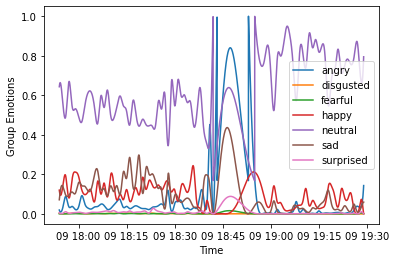

In [ ]:
sns.lineplot(x="timestamp", y="angry", data=fer_jazz_rehearsal, label='angry')
sns.lineplot(x="timestamp", y="disgusted", data=fer_jazz_rehearsal, label='disgusted')
sns.lineplot(x="timestamp", y="fearful", data=fer_jazz_rehearsal, label='fearful')
sns.lineplot(x="timestamp", y="happy", data=fer_jazz_rehearsal, label='happy')
sns.lineplot(x="timestamp", y="neutral", data=fer_jazz_rehearsal, label='neutral')
sns.lineplot(x="timestamp", y="sad", data=fer_jazz_rehearsal, label='sad')
sns.lineplot(x="timestamp", y="surprised", data=fer_jazz_rehearsal, label='surprised')


plt.ylabel("Group Emotions")
plt.xlabel("Time")
plt.show()

## Correlations of FER and SPI

In [ ]:
spi_jazz_rehearsal.corr()

,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7
MFCC 0,1.000000,0.926874,-0.627622,-0.943556,-0.917806,-0.925132,-0.937108,-0.945409
MFCC 1,0.926874,1.000000,-0.313904,-0.808976,-0.741021,-0.786066,-0.852257,-0.883213
MFCC 2,-0.627622,-0.313904,1.000000,0.789604,0.796737,0.753452,0.674475,0.635098
MFCC 3,-0.943556,-0.808976,0.789604,1.000000,0.956522,0.943455,0.937997,0.925710
MFCC 4,-0.917806,-0.741021,0.796737,0.956522,1.000000,0.963452,0.908352,0.866831
MFCC 5,-0.925132,-0.786066,0.753452,0.943455,0.963452,1.000000,0.969091,0.909673
MFCC 6,-0.937108,-0.852257,0.674475,0.937997,0.908352,0.969091,1.000000,0.968316
MFCC 7,-0.945409,-0.883213,0.635098,0.925710,0.866831,0.909673,0.968316,1.000000


In [ ]:
fer_spi_jazz_rehearsal = pd.merge_asof(fer_jazz_rehearsal, spi_jazz_rehearsal, on='timestamp')

In [ ]:
fer_spi_jazz_rehearsal.corr() #correlation matrix 

,angry,disgusted,fearful,happy,neutral,sad,surprised,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7
angry,1.000000,-0.176790,0.857991,-0.231067,-0.326872,0.524354,0.866800,0.294780,0.234932,-0.267040,-0.286871,-0.301149,-0.337054,-0.333569,-0.300700
disgusted,-0.176790,1.000000,-0.038095,0.428385,-0.388846,0.411812,0.006728,-0.226522,-0.219045,0.179032,0.273867,0.221278,0.262480,0.316027,0.287118
fearful,0.857991,-0.038095,1.000000,-0.282183,-0.191113,0.684706,0.968745,0.312860,0.250532,-0.290241,-0.305655,-0.308585,-0.348748,-0.333017,-0.294077
happy,-0.231067,0.428385,-0.282183,1.000000,-0.410501,-0.075622,-0.220123,-0.111846,-0.153178,0.019351,0.109087,0.039016,0.103596,0.166677,0.177280
neutral,-0.326872,-0.388846,-0.191113,-0.410501,1.000000,-0.394702,-0.263076,0.087797,0.162175,0.037833,-0.118543,-0.040101,-0.056582,-0.127657,-0.152812
sad,0.524354,0.411812,0.684706,-0.075622,-0.394702,1.000000,0.700009,0.038643,0.038967,-0.010869,0.015119,0.006262,-0.029698,-0.009965,-0.015670
surprised,0.866800,0.006728,0.968745,-0.220123,-0.263076,0.700009,1.000000,0.309034,0.229225,-0.305035,-0.297069,-0.318000,-0.346371,-0.324191,-0.295196
MFCC 0,0.294780,-0.226522,0.312860,-0.111846,0.087797,0.038643,0.309034,1.000000,0.926874,-0.627622,-0.943556,-0.917806,-0.925132,-0.937108,-0.945409
MFCC 1,0.234932,-0.219045,0.250532,-0.153178,0.162175,0.038967,0.229225,0.926874,1.000000,-0.313904,-0.808976,-0.741021,-0.786066,-0.852257,-0.883213
MFCC 2,-0.267040,0.179032,-0.290241,0.019351,0.037833,-0.010869,-0.305035,-0.627622,-0.313904,1.000000,0.789604,0.796737,0.753452,0.674475,0.635098


In [ ]:
# fer_jazz_mfcc7 = fer_spi_jazz_rehearsal.drop(['MFCC 0', 'MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 7'], axis = 1)

In [ ]:
# fer_only_emo = fer_spi_jazz_rehearsal.drop(['MFCC 0', 'MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 7'], axis = 1)

In [ ]:
# fer_jazz_mfcc7.set_index("timestamp", inplace = True)

In [ ]:
# fer_only_emo.set_index("timestamp", inplace = True)

Correlation Matrix with MFCC 6 representing MFCC coefficients 

In [ ]:
# fer_only_emo

In [ ]:
# fer_jazz_mfcc7

In [ ]:
# fer_jazz_mfcc7.to_csv('fer_plant.csv')

In [ ]:
# files.download("fer_plant.csv")

Seaborn Triangle HeatMap

In [ ]:
# mask = np.triu(np.ones_like(fer_jazz_mfcc7.corr()))
# dataplot = sns.heatmap(fer_jazz_mfcc7.corr(), cmap="YlGnBu", annot=True, mask=mask)
# plt.show()

In [ ]:
# mask2 = np.triu(np.ones_like(fer_only_emo.corr()))
# dataplot2 = sns.heatmap(fer_only_emo.corr(), cmap="YlGnBu", annot=True, mask=mask2)
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="angry", data=fer_spi_jazz_rehearsal, label='Anger')

# plt.ylabel("Jazz Rehearsal : MFCCs X Anger")
# plt.xlabel("Time")
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="surprised", data=fer_spi_jazz_rehearsal, label='Surprise')

# plt.ylabel("Jazz Rehearsal : MFCCs X Surprise")
# plt.xlabel("Time")
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="sad", data=fer_spi_jazz_rehearsal, label='Sadness')

# plt.ylabel("Jazz Rehearsal : MFCCs X Sadness")
# plt.xlabel("Time")
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="neutral", data=fer_spi_jazz_rehearsal, label='Neutral')

# plt.ylabel("Jazz Rehearsal : MFCCs X Neutral")
# plt.xlabel("Time")
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="happy", data=fer_spi_jazz_rehearsal, label='Happiness')

# plt.ylabel("Jazz Rehearsal : MFCCs X Happiness")
# plt.xlabel("Time")
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="disgusted", data=fer_spi_jazz_rehearsal, label='Disgust')

# plt.ylabel("Jazz Rehearsal : MFCCs X Disgust")
# plt.xlabel("Time")
# plt.show()

In [ ]:
# sns.lineplot(x="timestamp", y="MFCC 6", data=fer_spi_jazz_rehearsal, label='MFCC')
# sns.lineplot(x="timestamp", y="fearful", data=fer_spi_jazz_rehearsal, label='Fear')

# plt.ylabel("Jazz Rehearsal : MFCCs X Fear")
# plt.xlabel("Time")
# plt.show()

Pearson's Correlation Coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['fearful'])
# print('Pearsons correlation: %.3f' %corr)
# print('Significance Value: %.3f' %sig)

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['angry'])
# print('Pearsons correlation: %.3f' % corr)
# print('Significance Value: %.3f' %sig)

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['sad'])
# print('Pearsons correlation: %.3f' % corr)
# print('Significance Value: %.3f' %sig)

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['neutral'])
# print('Pearsons correlation: %.3f' % corr)
# print('Significance Value: %.3f' %sig)

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['happy'])
# print('Pearsons correlation: %.3f' %corr)
# print('Significance Value: %.3f' %sig)

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['disgusted'])
# print('Pearsons correlation: %.3f' %corr)
# print('Significance Value: %.3f' %sig)

In [ ]:
# corr, sig = pearsonr(fer_spi_jazz_rehearsal['MFCC 6'], fer_spi_jazz_rehearsal['surprised'])
# print('Pearsons correlation: %.3f' %corr)
# print('Significance Value: %.3f' %sig)

## ML Model

In [ ]:
fer_spi_jazz_rehearsal

,timestamp,angry,disgusted,fearful,happy,neutral,sad,surprised,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7
0,2022-03-09 17:54:00,0.019677,0.003133,0.000532,0.120099,0.643036,0.071537,0.006573,0.299310,0.642983,0.924750,0.868203,0.842421,0.738736,0.673170,0.688342
1,2022-03-09 17:54:01,0.018628,0.002999,0.000510,0.117711,0.645566,0.074226,0.006117,0.299162,0.642209,0.923871,0.868588,0.842883,0.738640,0.673888,0.689141
2,2022-03-09 17:54:02,0.017659,0.002871,0.000488,0.115467,0.647920,0.076890,0.005693,0.299017,0.641461,0.923026,0.868968,0.843336,0.738547,0.674580,0.689911
3,2022-03-09 17:54:03,0.016766,0.002749,0.000468,0.113363,0.650100,0.079526,0.005300,0.298877,0.640738,0.922213,0.869345,0.843779,0.738459,0.675248,0.690652
4,2022-03-09 17:54:04,0.015943,0.002633,0.000449,0.111392,0.652108,0.082130,0.004936,0.298742,0.640040,0.921433,0.869717,0.844213,0.738374,0.675893,0.691363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5696,2022-03-09 19:28:56,0.124007,0.000103,0.000646,0.007886,0.764074,0.059461,0.001303,0.286433,0.623153,0.930009,0.895751,0.857226,0.733746,0.676273,0.698048
5697,2022-03-09 19:28:57,0.128555,0.000086,0.000499,0.006099,0.771208,0.059588,0.000992,0.285112,0.621356,0.930430,0.896655,0.857264,0.733820,0.676488,0.698278
5698,2022-03-09 19:28:58,0.133295,0.000071,0.000367,0.004493,0.778651,0.059677,0.000715,0.283786,0.619545,0.930842,0.897549,0.857276,0.733872,0.676683,0.698485
5699,2022-03-09 19:28:59,0.138233,0.000056,0.000251,0.003092,0.786408,0.059728,0.000475,0.282454,0.617721,0.931246,0.898433,0.857260,0.733902,0.676856,0.698668


In [ ]:
fer_spi_jazz_rehearsal = fer_spi_jazz_rehearsal.set_index('timestamp')

In [ ]:
downsample = fer_spi_jazz_rehearsal.resample('10S').mean()

In [ ]:
downsample

,angry,disgusted,fearful,happy,neutral,sad,surprised,MFCC 0,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7
timestamp,,,,,,,,,,,,,,,
2022-03-09 17:54:00,0.015823,0.002600,0.000444,0.110981,0.652352,0.083274,0.004872,0.298692,0.639800,0.921185,0.869886,0.844389,0.738348,0.676109,0.691592
2022-03-09 17:54:10,0.010788,0.001723,0.000308,0.098097,0.662807,0.106748,0.002504,0.297563,0.634199,0.915197,0.873384,0.848205,0.737707,0.681209,0.697098
2022-03-09 17:54:20,0.009554,0.001204,0.000237,0.094505,0.659039,0.124898,0.001532,0.296761,0.630663,0.911953,0.876536,0.851224,0.737382,0.684285,0.700197
2022-03-09 17:54:30,0.010954,0.000914,0.000208,0.097997,0.644092,0.136935,0.001277,0.296202,0.628828,0.911029,0.879386,0.853555,0.737327,0.685663,0.701303
2022-03-09 17:54:40,0.014829,0.000769,0.000209,0.107165,0.621221,0.142935,0.001475,0.295805,0.628335,0.911999,0.881980,0.855311,0.737495,0.685668,0.700835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-09 19:28:20,0.047848,0.000562,0.005424,0.070452,0.663614,0.042188,0.011322,0.323652,0.671105,0.913851,0.864655,0.845535,0.722854,0.661395,0.681727
2022-03-09 19:28:30,0.061757,0.000479,0.004532,0.057186,0.673950,0.049562,0.009556,0.312984,0.657905,0.919386,0.874711,0.850958,0.727707,0.667407,0.688350
2022-03-09 19:28:40,0.083918,0.000321,0.002834,0.035014,0.702923,0.055543,0.005982,0.301126,0.642692,0.924625,0.884753,0.854971,0.731411,0.672375,0.693806


In [ ]:
downsample.drop(['MFCC 0'], axis = 1)

,angry,disgusted,fearful,happy,neutral,sad,surprised,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7
timestamp,,,,,,,,,,,,,,
2022-03-09 17:54:00,0.015823,0.002600,0.000444,0.110981,0.652352,0.083274,0.004872,0.639800,0.921185,0.869886,0.844389,0.738348,0.676109,0.691592
2022-03-09 17:54:10,0.010788,0.001723,0.000308,0.098097,0.662807,0.106748,0.002504,0.634199,0.915197,0.873384,0.848205,0.737707,0.681209,0.697098
2022-03-09 17:54:20,0.009554,0.001204,0.000237,0.094505,0.659039,0.124898,0.001532,0.630663,0.911953,0.876536,0.851224,0.737382,0.684285,0.700197
2022-03-09 17:54:30,0.010954,0.000914,0.000208,0.097997,0.644092,0.136935,0.001277,0.628828,0.911029,0.879386,0.853555,0.737327,0.685663,0.701303
2022-03-09 17:54:40,0.014829,0.000769,0.000209,0.107165,0.621221,0.142935,0.001475,0.628335,0.911999,0.881980,0.855311,0.737495,0.685668,0.700835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-09 19:28:20,0.047848,0.000562,0.005424,0.070452,0.663614,0.042188,0.011322,0.671105,0.913851,0.864655,0.845535,0.722854,0.661395,0.681727
2022-03-09 19:28:30,0.061757,0.000479,0.004532,0.057186,0.673950,0.049562,0.009556,0.657905,0.919386,0.874711,0.850958,0.727707,0.667407,0.688350
2022-03-09 19:28:40,0.083918,0.000321,0.002834,0.035014,0.702923,0.055543,0.005982,0.642692,0.924625,0.884753,0.854971,0.731411,0.672375,0.693806


In [ ]:
X_fer_spi = downsample[["MFCC 1", "MFCC 2", "MFCC 3", "MFCC 4", "MFCC 5", "MFCC 6", "MFCC 7"]]
X_fer_spi.reset_index(inplace = True) 
X_fer_spi = X_fer_spi.drop(['timestamp'], axis = 1)

In [ ]:
Y_fer_spi = downsample[["angry", "disgusted", "sad", "surprised", "happy", "fearful"]]

In [ ]:
Y_fer_spi

,angry,disgusted,sad,surprised,happy,fearful
timestamp,,,,,,
2022-03-09 17:54:00,0.015823,0.002600,0.083274,0.004872,0.110981,0.000444
2022-03-09 17:54:10,0.010788,0.001723,0.106748,0.002504,0.098097,0.000308
2022-03-09 17:54:20,0.009554,0.001204,0.124898,0.001532,0.094505,0.000237
2022-03-09 17:54:30,0.010954,0.000914,0.136935,0.001277,0.097997,0.000208
2022-03-09 17:54:40,0.014829,0.000769,0.142935,0.001475,0.107165,0.000209
...,...,...,...,...,...,...
2022-03-09 19:28:20,0.047848,0.000562,0.042188,0.011322,0.070452,0.005424
2022-03-09 19:28:30,0.061757,0.000479,0.049562,0.009556,0.057186,0.004532
2022-03-09 19:28:40,0.083918,0.000321,0.055543,0.005982,0.035014,0.002834


In [ ]:
def add(a, b, c, d, e, f):
    return a + b + c + d + e + f

def div(sum):
    return (1/sum)

In [ ]:
Y_fer_spi['add'] = Y_fer_spi.apply(lambda row : add(row['angry'], row['disgusted'], row['sad'], row['surprised'], row['happy'], row['fearful']), axis = 1)
Y_fer_spi['coeff'] = Y_fer_spi.apply(lambda row : div(row['add']), axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Y_fer_spi

,angry,disgusted,sad,surprised,happy,fearful,add,coeff
timestamp,,,,,,,,
2022-03-09 17:54:00,0.015823,0.002600,0.083274,0.004872,0.110981,0.000444,0.217994,4.587275
2022-03-09 17:54:10,0.010788,0.001723,0.106748,0.002504,0.098097,0.000308,0.220167,4.542012
2022-03-09 17:54:20,0.009554,0.001204,0.124898,0.001532,0.094505,0.000237,0.231930,4.311644
2022-03-09 17:54:30,0.010954,0.000914,0.136935,0.001277,0.097997,0.000208,0.248285,4.027630
2022-03-09 17:54:40,0.014829,0.000769,0.142935,0.001475,0.107165,0.000209,0.267381,3.739987
...,...,...,...,...,...,...,...,...
2022-03-09 19:28:20,0.047848,0.000562,0.042188,0.011322,0.070452,0.005424,0.177796,5.624431
2022-03-09 19:28:30,0.061757,0.000479,0.049562,0.009556,0.057186,0.004532,0.183071,5.462349
2022-03-09 19:28:40,0.083918,0.000321,0.055543,0.005982,0.035014,0.002834,0.183611,5.446306


In [ ]:
Y_fer_spi_new = Y_fer_spi[["angry", "disgusted", "sad", "surprised", "happy", "fearful"]].multiply(Y_fer_spi["coeff"], axis="index")

In [ ]:
Y_fer_spi_new

,angry,disgusted,sad,surprised,happy,fearful
timestamp,,,,,,
2022-03-09 17:54:00,0.072585,0.011926,0.382000,0.022350,0.509100,0.002039
2022-03-09 17:54:10,0.048997,0.007826,0.484849,0.011372,0.445559,0.001397
2022-03-09 17:54:20,0.041193,0.005192,0.538516,0.006605,0.407471,0.001021
2022-03-09 17:54:30,0.044119,0.003679,0.551522,0.005144,0.394697,0.000838
2022-03-09 17:54:40,0.055459,0.002875,0.534574,0.005515,0.400797,0.000780
...,...,...,...,...,...,...
2022-03-09 19:28:20,0.269118,0.003163,0.237281,0.063682,0.396250,0.030506
2022-03-09 19:28:30,0.337340,0.002615,0.270725,0.052196,0.312370,0.024754
2022-03-09 19:28:40,0.457041,0.001746,0.302503,0.032579,0.190696,0.015435


In [ ]:
Y_fer_spi['add'] = Y_fer_spi.apply(lambda row : add(row['angry'], row['disgusted'], row['sad'], row['surprised'], row['happy'], row['fearful']), axis = 1)


In [ ]:
for i in range(0,571):
  

In [ ]:
# sns.lineplot(x="timestamp", y="angry", data=Y_fer_spi, label='angry')
# sns.lineplot(x="timestamp", y="disgusted", data=Y_fer_spi, label='disgusted')
# sns.lineplot(x="timestamp", y="sad", data=Y_fer_spi, label='sad')
# sns.lineplot(x="timestamp", y="surprised", data=Y_fer_spi, label='surprised')
# sns.lineplot(x="timestamp", y="neutral", data=Y_fer_spi, label='neutral')
# sns.lineplot(x="timestamp", y="happy", data=Y_fer_spi, label='happy')
# sns.lineplot(x="timestamp", y="fearful", data=Y_fer_spi, label='fearful')

# plt.ylabel("Group Emotions")
# plt.xlabel("Time")
# plt.show()

In [ ]:
Y_fer_spi['max_value'] = Y_fer_spi.max(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Y_fer_spi

,angry,disgusted,sad,surprised,happy,fearful,max_value
timestamp,,,,,,,
2022-03-09 17:54:00,0.015823,0.002600,0.083274,0.004872,0.110981,0.000444,0.110981
2022-03-09 17:54:10,0.010788,0.001723,0.106748,0.002504,0.098097,0.000308,0.106748
2022-03-09 17:54:20,0.009554,0.001204,0.124898,0.001532,0.094505,0.000237,0.124898
2022-03-09 17:54:30,0.010954,0.000914,0.136935,0.001277,0.097997,0.000208,0.136935
2022-03-09 17:54:40,0.014829,0.000769,0.142935,0.001475,0.107165,0.000209,0.142935
...,...,...,...,...,...,...,...
2022-03-09 19:28:20,0.047848,0.000562,0.042188,0.011322,0.070452,0.005424,0.070452
2022-03-09 19:28:30,0.061757,0.000479,0.049562,0.009556,0.057186,0.004532,0.061757
2022-03-09 19:28:40,0.083918,0.000321,0.055543,0.005982,0.035014,0.002834,0.083918


In [ ]:
Y_fer_spi.reset_index(inplace = True)

In [ ]:
Y_fer_spi.drop(['timestamp'], axis = 1)

,angry,disgusted,sad,surprised,happy,fearful,max_value
0,0.015823,0.002600,0.083274,0.004872,0.110981,0.000444,0.110981
1,0.010788,0.001723,0.106748,0.002504,0.098097,0.000308,0.106748
2,0.009554,0.001204,0.124898,0.001532,0.094505,0.000237,0.124898
3,0.010954,0.000914,0.136935,0.001277,0.097997,0.000208,0.136935
4,0.014829,0.000769,0.142935,0.001475,0.107165,0.000209,0.142935
...,...,...,...,...,...,...,...
566,0.047848,0.000562,0.042188,0.011322,0.070452,0.005424,0.070452
567,0.061757,0.000479,0.049562,0.009556,0.057186,0.004532,0.061757
568,0.083918,0.000321,0.055543,0.005982,0.035014,0.002834,0.083918
569,0.118252,0.000132,0.059061,0.001916,0.011385,0.000932,0.118252


In [ ]:
for i in range(0,571):
  if (Y_fer_spi['angry'][i] == Y_fer_spi['max_value'][i]):
    Y_fer_spi['max_value'][i] = 'angry'
  elif (Y_fer_spi['disgusted'][i] == Y_fer_spi['max_value'][i]):
    Y_fer_spi['max_value'][i] = 'disgusted'
  elif (Y_fer_spi['sad'][i] == Y_fer_spi['max_value'][i]):
    Y_fer_spi['max_value'][i] = 'sad'
  elif (Y_fer_spi['happy'][i] == Y_fer_spi['max_value'][i]):
    Y_fer_spi['max_value'][i] = 'happy'
  elif (Y_fer_spi['fearful'][i] == Y_fer_spi['max_value'][i]):
    Y_fer_spi['max_value'][i] = 'fearful'
  else:
    Y_fer_spi['max_value'][i] = 'surprised'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = s

In [ ]:
Y_fer_spi

,timestamp,angry,disgusted,sad,surprised,happy,fearful,max_value
0,2022-03-09 17:54:00,0.015823,0.002600,0.083274,0.004872,0.110981,0.000444,happy
1,2022-03-09 17:54:10,0.010788,0.001723,0.106748,0.002504,0.098097,0.000308,sad
2,2022-03-09 17:54:20,0.009554,0.001204,0.124898,0.001532,0.094505,0.000237,sad
3,2022-03-09 17:54:30,0.010954,0.000914,0.136935,0.001277,0.097997,0.000208,sad
4,2022-03-09 17:54:40,0.014829,0.000769,0.142935,0.001475,0.107165,0.000209,sad
...,...,...,...,...,...,...,...,...
566,2022-03-09 19:28:20,0.047848,0.000562,0.042188,0.011322,0.070452,0.005424,happy
567,2022-03-09 19:28:30,0.061757,0.000479,0.049562,0.009556,0.057186,0.004532,angry
568,2022-03-09 19:28:40,0.083918,0.000321,0.055543,0.005982,0.035014,0.002834,angry
569,2022-03-09 19:28:50,0.118252,0.000132,0.059061,0.001916,0.011385,0.000932,angry


In [ ]:
Y_fer_spi.rename(columns = {'max_value':'class_type'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
Y_fer_spi.class_type.unique()

array(['happy', 'sad', 'angry'], dtype=object)

In [ ]:
print(Y_fer_spi['class_type'].value_counts()['happy'])
print(Y_fer_spi['class_type'].value_counts()['angry'])
print(Y_fer_spi['class_type'].value_counts()['sad'])

283
112
176


In [ ]:
# for i in range(0,5701):
#   if (Y_fer_spi['class_type'][i] == 'angry'):
#     Y_fer_spi['class_type'][i] = 1
#   elif (Y_fer_spi['class_type'][i] == 'sad'):
#     Y_fer_spi['class_type'][i] = 2
#   elif (Y_fer_spi['class_type'][i] == 'disgusted'):
#     Y_fer_spi['class_type'][i] = 3
#   else:
#     Y_fer_spi['class_type'][i] = 4

In [ ]:
Y_fer_spi

,timestamp,angry,disgusted,sad,surprised,happy,fearful,class_type
0,2022-03-09 17:54:00,0.015823,0.002600,0.083274,0.004872,0.110981,0.000444,happy
1,2022-03-09 17:54:10,0.010788,0.001723,0.106748,0.002504,0.098097,0.000308,sad
2,2022-03-09 17:54:20,0.009554,0.001204,0.124898,0.001532,0.094505,0.000237,sad
3,2022-03-09 17:54:30,0.010954,0.000914,0.136935,0.001277,0.097997,0.000208,sad
4,2022-03-09 17:54:40,0.014829,0.000769,0.142935,0.001475,0.107165,0.000209,sad
...,...,...,...,...,...,...,...,...
566,2022-03-09 19:28:20,0.047848,0.000562,0.042188,0.011322,0.070452,0.005424,happy
567,2022-03-09 19:28:30,0.061757,0.000479,0.049562,0.009556,0.057186,0.004532,angry
568,2022-03-09 19:28:40,0.083918,0.000321,0.055543,0.005982,0.035014,0.002834,angry
569,2022-03-09 19:28:50,0.118252,0.000132,0.059061,0.001916,0.011385,0.000932,angry


In [ ]:
Y_fer_spi = Y_fer_spi.drop(['timestamp', 'disgusted', 'sad', 'surprised','angry', 'happy', 'fearful'], axis = 1)

In [ ]:
fer_spi_data = pd.concat([X_fer_spi, Y_fer_spi], axis=1, join="inner")

In [ ]:
fer_spi_data

,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7,class_type
0,0.639800,0.921185,0.869886,0.844389,0.738348,0.676109,0.691592,happy
1,0.634199,0.915197,0.873384,0.848205,0.737707,0.681209,0.697098,sad
2,0.630663,0.911953,0.876536,0.851224,0.737382,0.684285,0.700197,sad
3,0.628828,0.911029,0.879386,0.853555,0.737327,0.685663,0.701303,sad
4,0.628335,0.911999,0.881980,0.855311,0.737495,0.685668,0.700835,sad
...,...,...,...,...,...,...,...,...
566,0.671105,0.913851,0.864655,0.845535,0.722854,0.661395,0.681727,happy
567,0.657905,0.919386,0.874711,0.850958,0.727707,0.667407,0.688350,angry
568,0.642692,0.924625,0.884753,0.854971,0.731411,0.672375,0.693806,angry
569,0.625765,0.929331,0.894340,0.857016,0.733510,0.675830,0.697567,angry


0 - angry
1- sad
2 - happy

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=1, n=283 (49.562%)
Class=2, n=176 (30.823%)
Class=0, n=112 (19.615%)


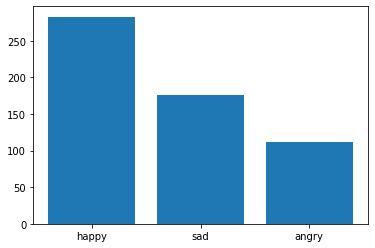

In [ ]:
y = LabelEncoder().fit_transform(Y_fer_spi)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
plt.bar(["happy", "sad", "angry"], counter.values())
plt.show()

In [ ]:
# # y = LabelEncoder().fit_transform(Y_fer_spi)
# encoder = LabelEncoder()
# encoder.fit(Y_fer_spi)
# encoded_Y = encoder.transform(Y_fer_spi)
# dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
# len(dummy_y)

In [ ]:
# len(X_fer_spi)

Class=1, n=283 (33.333%)
Class=2, n=283 (33.333%)
Class=0, n=283 (33.333%)


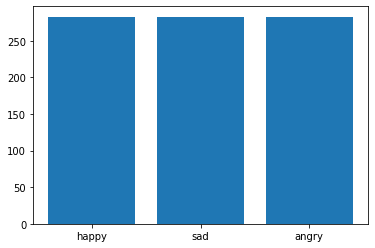

In [ ]:
y = LabelEncoder().fit_transform(Y_fer_spi)
oversample = SMOTE()
X, y = oversample.fit_resample(X_fer_spi, y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(["happy", "sad", "angry"], counter.values())
plt.show()

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
# Y_sample = Y_fer_spi.to_numpy(copy='True')
# X_sample = X_fer_spi.to_numpy(copy='True')

In [ ]:
# def Oversample(X_data,Y_data): #Using Smote obtain a 50-50 balanced dataset 

#   sm = SMOTE(random_state = 2)
#   X_train_res, Y_train_res = sm.fit_resample(X_data, Y_data.ravel())
#   return X_train_res, Y_train_res

# X_new, Y_new = Oversample(X_sample,Y_sample)

In [ ]:
test_size = 0.30
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=test_size, random_state=seed)

In [ ]:
X_train.shape 

(594, 7)

In [ ]:
X_test.shape

(255, 7)

In [ ]:
y_train.shape

(594, 3)

In [ ]:
y_test.shape

(255, 3)

In [ ]:
X_np = X.to_numpy()

In [ ]:
X_np.shape

(849, 7)

In [ ]:
y.shape

(849,)

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=7, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train, batch_size=4, epochs=100)
accuracy = model.evaluate(X_test, y_test, batch_size=4)
print(accuracy)

Epoch 1/100
149/149 [==============================] - 3s 3ms/step - loss: 1.1015 - accuracy: 0.3047
Epoch 2/100
149/149 [==============================] - 0s 3ms/step - loss: 1.1006 - accuracy: 0.3485
Epoch 3/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0983 - accuracy: 0.3502
Epoch 4/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0985 - accuracy: 0.3215
Epoch 5/100
149/149 [==============================] - 0s 3ms/step - loss: 1.1004 - accuracy: 0.3519
Epoch 6/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0987 - accuracy: 0.3367
Epoch 7/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0978 - accuracy: 0.3199
Epoch 8/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0966 - accuracy: 0.3182
Epoch 9/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0946 - accuracy: 0.3519
Epoch 10/100
149/149 [==============================] - 0s 3ms/step - loss: 1.0930 - accura

KeyboardInterrupt: ignored

In [ ]:
evalset = [(X_train, y_train), (X_test,y_test)]

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=evalset)

[0]	validation_0-merror:0.343434	validation_0-mlogloss:1.06464	validation_1-merror:0.407843	validation_1-mlogloss:1.07424
[1]	validation_0-merror:0.326599	validation_0-mlogloss:1.03565	validation_1-merror:0.388235	validation_1-mlogloss:1.05483
[2]	validation_0-merror:0.338384	validation_0-mlogloss:1.00721	validation_1-merror:0.380392	validation_1-mlogloss:1.03616
[3]	validation_0-merror:0.326599	validation_0-mlogloss:0.982524	validation_1-merror:0.392157	validation_1-mlogloss:1.02059
[4]	validation_0-merror:0.323232	validation_0-mlogloss:0.95843	validation_1-merror:0.388235	validation_1-mlogloss:1.00649
[5]	validation_0-merror:0.314815	validation_0-mlogloss:0.937478	validation_1-merror:0.388235	validation_1-mlogloss:0.99087
[6]	validation_0-merror:0.299663	validation_0-mlogloss:0.919647	validation_1-merror:0.388235	validation_1-mlogloss:0.980146
[7]	validation_0-merror:0.308081	validation_0-mlogloss:0.902742	validation_1-merror:0.372549	validation_1-mlogloss:0.968536
[8]	validation_0-m

XGBClassifier(objective='multi:softprob')

In [ ]:
print(model)

XGBClassifier(objective='multi:softprob')


In [ ]:
results = model.evals_result()

In [ ]:
# yhat = model.predict(X_test)
# score = accuracy_score(y_test, yhat)
# print('Accuracy: %.5f' % score)

Accuracy: 0.69020


In [ ]:
# accuracy_score?

In [ ]:
# results = model.evals_result()

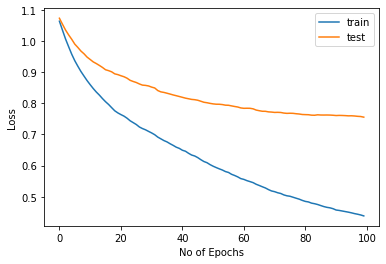

In [ ]:
# plt.plot(results['validation_0']['mlogloss'], label='train')
# plt.plot(results['validation_1']['mlogloss'], label='test')

# plt.ylabel("Loss")
# plt.xlabel("No of Epochs")
# plt.legend()
# plt.show()

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=yhat)

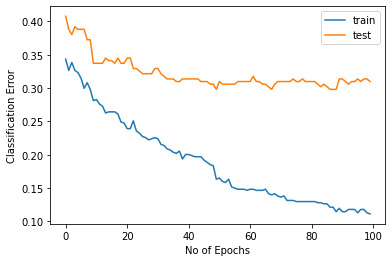

In [ ]:
# plt.plot(results['validation_0']['merror'], label='train')
# plt.plot(results['validation_1']['merror'], label='test')

# plt.ylabel("Classification Error")
# plt.xlabel("No of Epochs")
# plt.legend()
# plt.show()

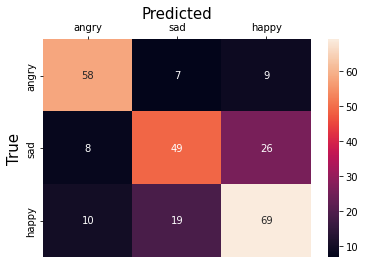

In [ ]:
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
# ax.set_xlabel('Predicted', fontsize=15)
# ax.xaxis.set_label_position('top') 
# ax.xaxis.set_ticklabels(['angry', 'sad', 'happy'], fontsize = 10)
# ax.xaxis.tick_top()

# ax.set_ylabel('True', fontsize=15)
# ax.yaxis.set_ticklabels(['angry', 'sad', 'happy'], fontsize = 10)
# plt.show()